# Automatic classification of eclipsing binary stars using deep learning methods

## Experiment 2
### Undersampling dataset

In [6]:
import numpy as np
import pandas as pd
import json
import pickle
np.random.seed(1234)

from keras.utils import np_utils
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Bidirectional, Flatten, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

     - load synthetic light curve - ELISa


In [7]:
data = pd.read_csv('../df_all.csv_v2')
data.head()

,Unnamed: 0,id,morphology,params,phases,generic_bessell_b,generic_bessell_v,generic_bessell_r,primary_t_eff,secondary_t_eff,primary_surface_potential,secondary_surface_potential,primary_mass,secondary_mass,period,inclination,spotty
0,0,1,over-contact,"{""system"": {""inclination"": 35.0, ""period"": 0.2...","[-0.6, -0.5878787878787879, -0.575757575757575...","[4.081591544439083e+23, 4.031652090826959e+23,...","[9.873049593587627e+23, 9.760395127000434e+23,...","[1.3747087279830434e+24, 1.3597310499829646e+2...",4000.0,4000.0,3.25,3.25,0.5,0.5,0.2,35.0,1
1,1,2,over-contact,"{""system"": {""inclination"": 35.0, ""period"": 0.3...","[-0.6, -0.5878787878787879, -0.575757575757575...","[6.858420674472336e+23, 6.77839214297677e+23, ...","[1.6727093360156839e+24, 1.6546225148187935e+2...","[2.3229246430355212e+24, 2.2990574599057018e+2...",4000.0,4000.0,3.25,3.25,0.5,0.5,0.3,35.0,1
2,2,3,over-contact,"{""system"": {""inclination"": 35.0, ""period"": 0.2...","[-0.6, -0.5878787878787879, -0.575757575757575...","[4.154670345913387e+23, 4.1078852654519154e+23...","[1.0057136315963416e+24, 9.95135723875756e+23,...","[1.3991268037182663e+24, 1.3849947154567012e+2...",4000.0,4000.0,3.25,3.25,0.5,0.5,0.2,35.0,0
3,3,4,over-contact,"{""system"": {""inclination"": 35.0, ""period"": 0.3...","[-0.6, -0.5878787878787879, -0.575757575757575...","[6.87545071052127e+23, 6.795238703023904e+23, ...","[1.6766406596411532e+24, 1.6585336954130392e+2...","[2.3278600928811596e+24, 2.3039841455496383e+2...",4000.0,4000.0,3.25,3.25,0.5,0.5,0.3,35.0,0
4,4,5,over-contact,"{""system"": {""inclination"": 35.0, ""period"": 0.5...","[-0.6, -0.5878787878787879, -0.575757575757575...","[1.496209461064851e+24, 1.4832596392814377e+24...","[3.6264470413553653e+24, 3.5968159381407736e+2...","[4.938565049205014e+24, 4.898473393857681e+24,...",4000.0,4000.0,3.25,3.25,0.5,0.5,0.5,35.0,1


    -  select and normalize data

In [48]:
data=data[data['spotty']==0]

for row in data['generic_bessell_v']:
     row = json.loads(row)

newData = []
for row in data['generic_bessell_v']:
    row = json.loads(row)
    minValueOfRow, maxValueOfRow = min(row), max(row)
    newRow = []
    for valueIndex in range(len(row)):
        row[valueIndex] = (row[valueIndex] - minValueOfRow) / (maxValueOfRow - minValueOfRow)
        newRow.append([row[valueIndex]])
    newData.append(newRow) 
    
newData = np.array(newData)

    - target by morphology

In [49]:
target = []
oc, dt = 0, 0
for row in data['morphology']:
    if row == 'over-contact':
        target.append(0)
        oc += 1
    elif row == 'detached':
        target.append(1)
        dt += 1      
target = np.array(target)

    - control the shape and check if the dataset is imbalanced

In [64]:
print(target.shape)
print(newData.shape)
print(Counter(target))

(491425,)
(491425, 100, 1)
Counter({1: 445556, 0: 45869})


    - define undersample strategy
    - fit and apply the transform

In [51]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_over, y_over = undersample.fit_resample(newData[:,:,0], target)

In [65]:
print(X_over.shape)
print(y_over.shape)
print(Counter(y_over))

(91738, 100)
(91738,)
Counter({0: 45869, 1: 45869})


    - add dimension to sequences
    - transform targets to categorical

In [54]:
y_over1 = np_utils.to_categorical(y_over, 2)
X_over1 = X_over[:, :, np.newaxis]

In [66]:
print(X_over1.shape)
print(y_over1.shape)
print(Counter(y_over))

(91738, 100, 1)
(91738, 2)
Counter({0: 45869, 1: 45869})


## Best model -> biLSTM + CNN

In [57]:
inputs = Input(shape=(100,1))
a = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputs)
a = Flatten()(a)
b = Conv1D(32, kernel_size = 3, padding = "valid", input_shape=(100,1))(inputs)
b = MaxPooling1D(2)(b)
b = Conv1D(32, kernel_size = 3, padding = "valid")(b)
b = MaxPooling1D(2)(b)
b = Flatten()(b)
x = concatenate([a,b])
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
classifier = Model(inputs=inputs, outputs=output)
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(classifier.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 98, 32)       128         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 49, 32)       0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 47, 32)       3104        max_pooling1d_2[0][0]            
_______________________________________________________________________________________

      - checkpoint: save only best model

In [ ]:
saved_model = "model_under_sample.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=3)
callbacks_list = [checkpoint, early]

    - training  

In [58]:
history = classifier.fit(X_over1, y_over1, validation_split=0.2, epochs=5, batch_size=32, verbose=1, callbacks = callbacks_list)

Epoch 1/5
2294/2294 [==============================] - ETA: 0s - loss: 0.0528 - acc: 0.9835
Epoch 00001: val_acc improved from -inf to 0.98038, saving model to model_under_sample.hdf5
2294/2294 [==============================] - 1286s 561ms/step - loss: 0.0528 - acc: 0.9835 - val_loss: 0.0479 - val_acc: 0.9804
Epoch 2/5
2294/2294 [==============================] - ETA: 0s - loss: 0.0123 - acc: 0.9967
Epoch 00002: val_acc improved from 0.98038 to 0.99188, saving model to model_under_sample.hdf5
2294/2294 [==============================] - 1285s 560ms/step - loss: 0.0123 - acc: 0.9967 - val_loss: 0.0213 - val_acc: 0.9919
Epoch 3/5
2294/2294 [==============================] - ETA: 0s - loss: 0.0073 - acc: 0.9980
Epoch 00003: val_acc improved from 0.99188 to 0.99613, saving model to model_under_sample.hdf5
2294/2294 [==============================] - 1285s 560ms/step - loss: 0.0073 - acc: 0.9980 - val_loss: 0.0107 - val_acc: 0.9961
Epoch 4/5
2294/2294 [==============================] - ETA

     - define function for plot loss and accuracy during training

In [59]:
def trainingLoss(history):
    plt.style.use('ggplot')
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('tarin1.png', bbox_inches='tight')
    plt.show()
    plt.style.use('ggplot')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('tarin2.png', )
    plt.show()

    - plot training graphs

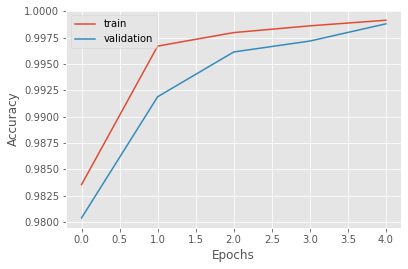

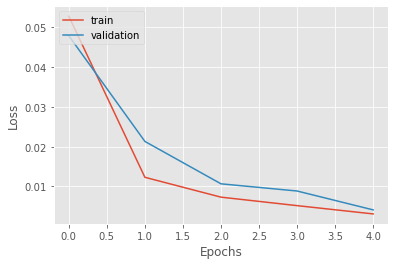

In [62]:
trainingLoss(history)